In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linspace
pi = np.pi
from mpl_toolkits import mplot3d
from matplotlib import cm # alternative color map
from matplotlib import gridspec # for creating cooler subplots

# rendering mp4 files
from matplotlib import animation

# playing video files
import io
import base64
from IPython.display import HTML

import mpl_toolkits.mplot3d.axes3d as p3

In [45]:
# play video-file
def playMP4(filename):
    video = io.open(filename, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

# rms error between numerical and ananlytical solution
def error(u, u_exact):
    Nx, Ny = u.shape
    err = 0
    for i in range(0,Nx):
        for j in range(0,Ny):
            err += (u[i,j]-u_exact[i,j])**2
    return err

In [3]:
# spacing of the 2d-grid
Nx = 17
Ny = 17
# number of iterations
Nt = 20

# define the intervals of the 2d-grid
ax = -1
ay = -1
bx = 1
by = 1

# initialize x, y and t space
x_int = linspace(ax, bx, Nx)
y_int = linspace(ay, by, Ny)
t_int = np.array(range(Nt))

# create boundary conditions
x0 = x_int**2-1
y0 = 1-y_int**2

# apply boundary conditions
u_init = np.zeros((Nx,Ny,Nt))
u_init[:,0,:]  = np.transpose(np.tile(x0, (Nt,1)))
u_init[:,-1,:] = np.transpose(np.tile(x0, (Nt,1)))
u_init[0,:,:]  = np.transpose(np.tile(y0, (Nt,1)))
u_init[-1,:,:] = np.transpose(np.tile(y0, (Nt,1)))

# create 2-d mesh
ymesh, xmesh = np.meshgrid(x_int, y_int)

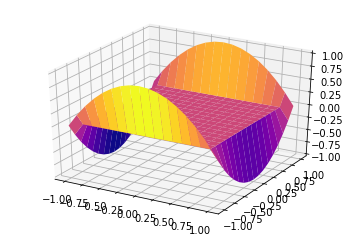

In [58]:
# plot boundary conditions
figBoundary = plt.figure()
pltBoundary = plt.axes(projection="3d")
pltBoundary.plot_surface(ymesh, xmesh, u_init[:,:,0], cmap="plasma", linewidth=0, antialiased=True)
plt.show()

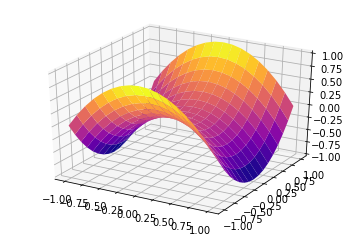

In [59]:
# define and plot the analytic solution

def analytic(x,y):
    return x**2-y**2

figAnalytic = plt.figure()
pltAnalytic = plt.axes(projection="3d")
u_analytic = analytic(xmesh, ymesh)
pltAnalytic.plot_surface(ymesh, xmesh, u_analytic, cmap="plasma", linewidth=0, antialiased=True)
plt.show()

In [35]:
# compute Jacobi- and SOR-iterations

u_Jac = np.copy(u_init)
u_SOR = np.copy(u_init)

for t in range(0,Nt-1):
    for i in range(1,Nx-1):
        for j in range(1,Ny-1):
            u_Jac[i,j,t+1] = 0.25*(u_Jac[i+1,j,t]+u_Jac[i-1,j,t]+u_Jac[i,j+1,t]+u_Jac[i,j-1,t])

om = 1.4
for t in range(0,Nt-1):
    for i in range(1,Nx-1):
        for j in range(1,Ny-1):
            u_SOR[i,j,t+1] = om*0.25*(u_SOR[i+1,j,t]+u_SOR[i-1,j,t+1]+u_SOR[i,j+1,t]+u_SOR[i,j-1,t+1]) + \
                             (1-om)*u_SOR[i,j,t]

In [36]:
# create new matrixes:
# by increasing the time index by 1,
# only one row gets updated.

Nt_small = (Nt-1)*(Nx-2)+1
u_Jac_rw = np.zeros((Nx, Ny, Nt_small))
u_SOR_rw = np.zeros((Nx, Ny, Nt_small))
u_Jac_rw[:,:,0] = u_Jac[:,:,0]
u_SOR_rw[:,:,0] = u_SOR[:,:,0]

t_small = 0
for t in range(0, Nt-1):
    for i in range(1, Nx-1):
        u_Jac_rw[:,:,t_small+1] = u_Jac_rw[:,:,t_small]
        u_Jac_rw[i,:,t_small+1] = u_Jac[i,:,t+1]
        
        u_SOR_rw[:,:,t_small+1] = u_SOR_rw[:,:,t_small]
        u_SOR_rw[i,:,t_small+1] = u_SOR[i,:,t+1]
        
        t_small += 1

## Convergence

In [37]:
# compute the convergence of Jac and SOR by rms

convergence_Jac = np.zeros(Nt)
convergence_SOR = np.zeros(Nt)

for t in range(0, Nt):
    convergence_Jac[t] = error(u_Jac[:,:,t], u_analytic)
    convergence_SOR[t] = error(u_SOR[:,:,t], u_analytic)

## Animation 

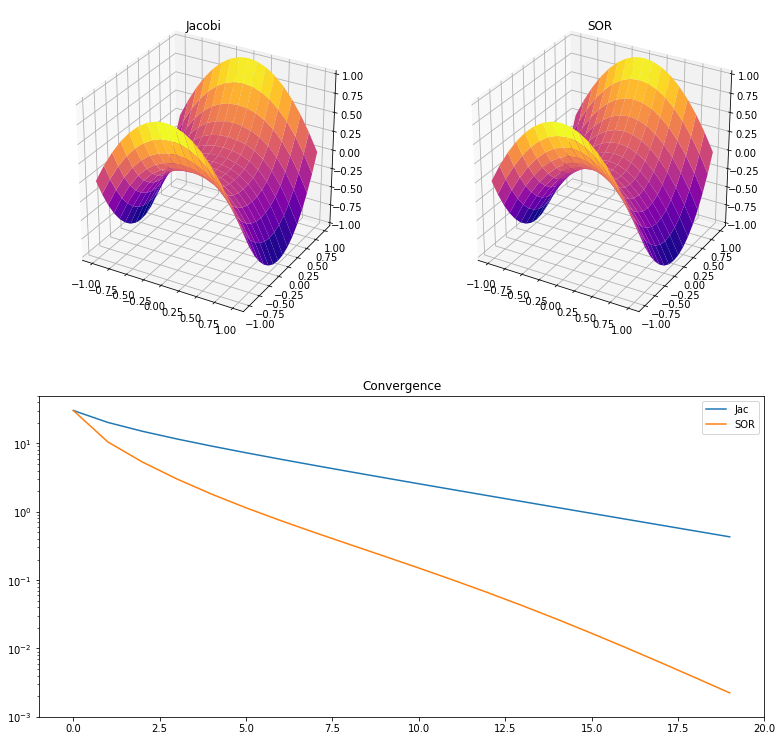

In [57]:
# create graphical tools and plot the end result

fig = plt.figure(figsize=(13,13))
grid = gridspec.GridSpec(2,2)
sub1 = fig.add_subplot(grid[0,0], projection='3d')
sub2 = fig.add_subplot(grid[0,1], projection='3d')
sub3 = fig.add_subplot(grid[1,:])

plot1 = sub1.plot_surface(ymesh, xmesh, u_Jac_rw[:,:,-1], cmap = "plasma", antialiased=True)
sub1.set_title("Jacobi")
plot2 = sub2.plot_surface(ymesh, xmesh, u_SOR_rw[:,:,-1], cmap = "plasma", antialiased=True)
sub2.set_title("SOR")

plot3 = sub3.semilogy(t_int, convergence_Jac, label="Jac")
plot3 = sub3.semilogy(t_int, convergence_SOR, label="SOR")
sub3.set_xlim(-1,Nt)
sub3.set_ylim(1E-3, 5E1)
sub3.set_title("Convergence")
sub3.legend()

plt.show()

In [52]:
# animate the calculation and save it as an mp4

def data_gen(framenumber, sol1, sol2, conv_Jac, conv_SOR, sub1, sub2, sub3):
    frame1 = sol1[:,:,framenumber]
    frame2 = sol2[:,:,framenumber]
    
    sub1.clear()
    plot1 = sub1.plot_surface(ymesh, xmesh, frame1, cmap = "plasma", antialiased=True)
    sub1.locator_params(axis='x', nbins=4)
    sub1.locator_params(axis='y', nbins=4)
    sub1.locator_params(axis='z', nbins=2)
    sub1.set_title('Jacobi Iteration\ni = %i' %(framenumber//(Nx-2)))
    
    sub2.clear()
    plot2 = sub2.plot_surface(ymesh, xmesh, frame2, cmap = "plasma", antialiased=True)
    sub2.locator_params(axis='x', nbins=4)
    sub2.locator_params(axis='y', nbins=4)
    sub2.locator_params(axis='z', nbins=2)
    sub2.set_title('SOR\ni = %i' %(framenumber//(Nx-2)))
    
    if np.mod(framenumber, Nx-2) == 0:
        sub3.clear()
        print("\t~~~~~~~~~\n\t",framenumber, np.mod(framenumber+1, Nx-2), framenumber//(Nx-2),"\n\t~~~~~~~~~")
        sub3.semilogy(t_int[:framenumber//(Nx-2)+1], conv_Jac[:framenumber//(Nx-2)+1], label="Jacobi")
        sub3.semilogy(t_int[:framenumber//(Nx-2)+1], conv_SOR[:framenumber//(Nx-2)+1], label="SOR")
        sub3.set_title('errors, frame = %i' % framenumber)
        sub3.set_xlim(-1,Nt)
        sub3.set_ylim(1E-3, 5E1)
        sub3.legend()
    return plot1, plot2

anim = animation.FuncAnimation(fig, data_gen, fargs=(u_Jac_rw, u_SOR_rw, convergence_Jac, convergence_SOR, \
                                                     sub1, sub2, sub3), frames=(Nt_small), blit=True)

anim.save('test.mp4', fps=20, extra_args=['-vcodec', 'libx264'])

plt.show()

	~~~~~~~~~
	 0 1 0 
	~~~~~~~~~
	~~~~~~~~~
	 0 1 0 
	~~~~~~~~~
	~~~~~~~~~
	 0 1 0 
	~~~~~~~~~
	~~~~~~~~~
	 15 1 1 
	~~~~~~~~~
	~~~~~~~~~
	 30 1 2 
	~~~~~~~~~
	~~~~~~~~~
	 45 1 3 
	~~~~~~~~~
	~~~~~~~~~
	 60 1 4 
	~~~~~~~~~
	~~~~~~~~~
	 75 1 5 
	~~~~~~~~~
	~~~~~~~~~
	 90 1 6 
	~~~~~~~~~
	~~~~~~~~~
	 105 1 7 
	~~~~~~~~~
	~~~~~~~~~
	 120 1 8 
	~~~~~~~~~
	~~~~~~~~~
	 135 1 9 
	~~~~~~~~~
	~~~~~~~~~
	 150 1 10 
	~~~~~~~~~
	~~~~~~~~~
	 165 1 11 
	~~~~~~~~~
	~~~~~~~~~
	 180 1 12 
	~~~~~~~~~
	~~~~~~~~~
	 195 1 13 
	~~~~~~~~~
	~~~~~~~~~
	 210 1 14 
	~~~~~~~~~
	~~~~~~~~~
	 225 1 15 
	~~~~~~~~~
	~~~~~~~~~
	 240 1 16 
	~~~~~~~~~
	~~~~~~~~~
	 255 1 17 
	~~~~~~~~~
	~~~~~~~~~
	 270 1 18 
	~~~~~~~~~
	~~~~~~~~~
	 285 1 19 
	~~~~~~~~~


In [53]:
playMP4("test.mp4")